In [81]:
import networkx as nx
from networkx.algorithms import isomorphism
import numpy as np
import matplotlib as plt
import os
import scipy.special
import json
import torch

In [49]:
# Generate a dataset of random, simple, complete graphs
full_dataset_name = "full_graph_dataset"
num_nodes = 10
graphs_per_edge_number = 10

In [50]:
edge_num_low = num_nodes - 1  # Lowest number of edges (|V| - 1)
edge_num_hi = int(scipy.special.binom(num_nodes, 2))  # Highest number of edges (complete graph)
os.makedirs(full_dataset_name, exist_ok=True)
counter = 0
for i in range(edge_num_low, edge_num_hi):
    for j in range(graphs_per_edge_number):
        graph = nx.dense_gnm_random_graph(num_nodes, i)  # Generate a random simple graph
        if nx.is_connected(graph):  # Record the graph if it is connected
            for k in range(len(list(graph.degree))):  # Set node attribute to be node degree
                graph.nodes[k]['deg'] = list(graph.degree)[k][1]
            nx.write_gml(graph, full_dataset_name + "/graph." + "{:04d}".format(counter))  # Write graph to file
            counter += 1

In [51]:
# Generate a training dataset of graphs with deleted edges and corresponding subisomorphism targets
training_dataset_name = "training_graph_dataset"

In [52]:
os.makedirs(training_dataset_name, exist_ok=True)
for root, subfolders, files in os.walk(full_dataset_name):
    for f in files:
        path = os.path.join(root, f)  # File path of a graph
        graph_number = f[-4:]
        original_graph = nx.read_gml(path, destringizer=int)  # Read a graph from file
        new_graph = original_graph.copy()  # Make a copy of the graph 
        d = 0.2*np.random.uniform(0, 1) + 0.7*np.random.beta(3, 3)  # Random fraction of remaining edges
        num_deletions = int((1 - d)*(len(list(original_graph.edges))))  # Integer number of edges to delete 
        for _ in range(num_deletions):  # Delete edges from the graph
            num_edge_to_delete = np.random.randint(0, len(list(new_graph.edges)))
            new_graph.remove_edge(list(new_graph.edges)[num_edge_to_delete][0], list(new_graph.edges)[num_edge_to_delete][1])
        
        target = np.zeros([num_nodes, num_nodes])  # Target matrix showing subisomorphic edge additions as 1s
        test_graph = new_graph.copy()  # Make a copy of the new, deleted-edges graph
        for i in range(num_nodes):
            for j in range(num_nodes):  
                if i < j and (i, j) not in new_graph.edges and test_graph.degree[i] < test_graph.nodes[i]['deg'] and test_graph.degree[j] < test_graph.nodes[j]['deg']:  # Check that i < j so we don't doulbe count edges, that (i, j) is not already in the graph, and that adding edge (i, j) doesn't violate any degree constraints
                    test_graph.add_edge(i, j)  # Try adding a new edge between nodes i and j and check if it is subisomorphic
                    if isomorphism.GraphMatcher(nx.line_graph(original_graph), nx.line_graph(test_graph)).subgraph_is_isomorphic():
                        target[i, j] = 1.0
                        target[j, i] = 1.0
                    test_graph = new_graph.copy()
        
        nx.write_gml(new_graph, training_dataset_name + "/partial_graph." + graph_number)
        np.savetxt(training_dataset_name + "/target." + graph_number, target)

KeyboardInterrupt: 

In [53]:
# Test an example
original_graph = nx.read_gml(full_dataset_name + "/graph.0082", destringizer=int)
partial_graph = nx.read_gml(training_dataset_name + "/partial_graph.0082", destringizer=int)
target = np.loadtxt(training_dataset_name + "/target.0082")

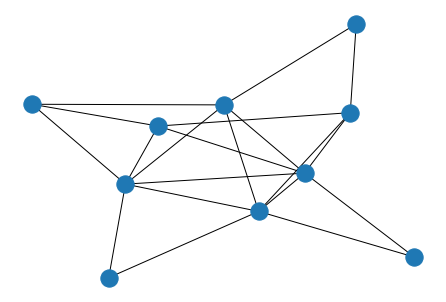

In [54]:
nx.draw(original_graph)

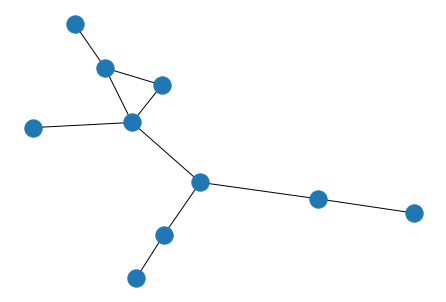

In [55]:
nx.draw(partial_graph)

In [56]:
print(target)
print(partial_graph.edges)

[[0. 1. 1. 1. 0. 1. 0. 0. 1. 0.]
 [1. 0. 1. 0. 0. 1. 1. 0. 1. 1.]
 [1. 1. 0. 1. 0. 1. 0. 0. 1. 1.]
 [1. 0. 1. 0. 0. 1. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 1. 0. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 1. 1. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 1. 0. 0. 0.]]
[(0, 6), (0, 7), (0, 9), (1, 3), (2, 6), (3, 4), (3, 9), (4, 9), (5, 7), (8, 9)]


In [69]:
test_graph = partial_graph.copy()
test_graph.add_edge(0, 8)
isomorphism.GraphMatcher(nx.line_graph(original_graph), nx.line_graph(test_graph)).subgraph_is_isomorphic()

True

In [70]:
print(partial_graph.degree[8])
print(partial_graph.nodes[8])

1
{'deg': 4}


In [80]:
# Create metadata file 
metadata_folder_name = "metadata"
metadata_file_name = "metadata.json"
data = []
for root, subfolders, files in os.walk(training_dataset_name):
    for f in files:
        if f[:7] == "partial":
            graph_path = os.path.join(root, f)
            target_path = os.path.join(root, "target."+f[-4:])
            uid = f[f.find('.') + 1:f.find('.') + 5]
            data.append({'graph_path': graph_path, 'target_path': target_path, 'uid': uid})
os.makedirs(metadata_folder_name, exist_ok=True)
json.dump(data, open(metadata_folder_name+'/'+metadata_file_name, 'w'), indent=4, sort_keys=True)